In [1]:
import pandas as pd
import mido
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
MAESTRO_FOLDER = '../maestro-v3.0.0'
maestro_csv = os.path.join(MAESTRO_FOLDER, 'maestro-v3.0.0.csv')
maestro_df = pd.read_csv(maestro_csv)
maestro_df

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2018,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...,698.661160
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
3,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
4,Alexander Scriabin,"3 Etudes, Op. 65",validation,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508
...,...,...,...,...,...,...,...
1271,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",test,2004,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,241.470442
1272,Wolfgang Amadeus Mozart,"Sonata in F Major, K280",train,2004,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MI...,114.696243
1273,Wolfgang Amadeus Mozart,"Sonata in F Major, K533",validation,2004,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORI...,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORI...,1139.198478
1274,Wolfgang Amadeus Mozart,"Sonata in F Major, K533/K494",validation,2018,2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_...,2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_...,1068.751602


# Get the pedal events for a single midi file

In [3]:
example_midi = os.path.join(MAESTRO_FOLDER, maestro_df.iloc[0]['midi_filename'])
print(example_midi)

for message in mido.MidiFile(example_midi):
    if message.is_cc(64):
        assert message.channel == 0
        print(message)
        # time actually represents the time since the last message, not duration of the message
        print(message.value, message.time)

../maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi
control_change channel=0 control=64 value=127 time=0
127 0
control_change channel=0 control=64 value=117 time=0.16666666666666666
117 0.16666666666666666
control_change channel=0 control=64 value=111 time=0.01953125
111 0.01953125
control_change channel=0 control=64 value=107 time=0.020833333333333332
107 0.020833333333333332
control_change channel=0 control=64 value=103 time=0.01953125
103 0.01953125
control_change channel=0 control=64 value=98 time=0.00390625
98 0.00390625
control_change channel=0 control=64 value=93 time=0.018229166666666664
93 0.018229166666666664
control_change channel=0 control=64 value=85 time=0.010416666666666666
85 0.010416666666666666
control_change channel=0 control=64 value=79 time=0.018229166666666664
79 0.018229166666666664
control_change channel=0 control=64 value=73 time=0.020833333333333332
73 0.020833333333333332
control_change channel=0 control=64 value=69 time=0.01953

## Get a subset of Maestro

In [4]:
maestro_subset = maestro_df.sample(frac=1/50, random_state=42)

In [5]:
# process pedal events into a list
def add_pedal_events_col(df):
    all_pedal_events = []
    for midi_base in tqdm(df['midi_filename']):
        file_name = os.path.join(MAESTRO_FOLDER, midi_base)

        # List to store (value, time_until_next) pairs for sustain pedal messages
        pedal_events = []
        time_until_next = 0
        # Iterate over messages in reverse
        for message in reversed(list(mido.MidiFile(file_name))):
            if message.type == 'control_change' and message.control == 64:
                # Store the pedal message value and time until the next pedal message
                pedal_events.append((message.value, time_until_next))
                time_until_next = 0  # Reset time counter after recording this pedal message
            time_until_next += message.time  # Accumulate time backwards

        all_pedal_events.append(pd.DataFrame(pedal_events, columns=['level', 'duration']))
    
    df = df.assign(pedal_events=all_pedal_events)
    return df

maestro_subset = add_pedal_events_col(maestro_subset)
maestro_subset['pedal_events']

100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:06<00:00,  4.03it/s]


101          level  duration
0        0  5.652344
1   ...
51            level  duration
0         0  0.864583
1 ...
76           level  duration
0        0  0.001302
1   ...
644           level  duration
0        40  0.001302
1 ...
425            level  duration
0          0  0.001302
...
745          level   duration
0        0  11.978125
1 ...
1211          level  duration
0        58  0.001042
1 ...
1236          level  duration
0         0  3.410156
1 ...
596           level  duration
0         0  0.001302
1 ...
275           level  duration
0         0  0.001042
1 ...
289           level  duration
0         0  0.001302
1 ...
1030          level  duration
0        51  0.001042
1 ...
707           level  duration
0        24  0.001302
1 ...
583           level  duration
0         0  0.001042
1 ...
1223          level  duration
0         0  0.001302
1 ...
63            level  duration
0         0  0.001302
1 ...
946           level  duration
0         0  0.001302
1 ...
1061          

In [6]:
all_events = pd.concat(maestro_subset['pedal_events'].to_list(), ignore_index=True)
all_events

,level,duration
0,0,5.652344
1,63,0.022135
2,84,0.019531
3,114,0.019531
4,127,0.158854
...,...,...
146404,84,0.019531
146405,91,0.019531
146406,99,0.019531
146407,110,0.019531


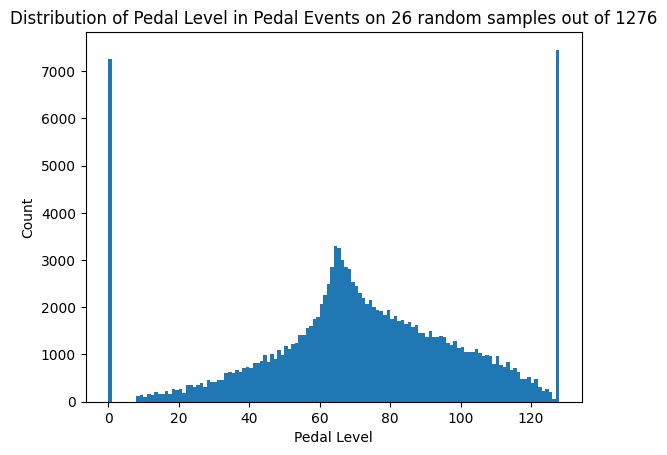

In [8]:
counts, bin_edges, patches = plt.hist(all_events['level'], bins=range(129))
plt.xlabel("Pedal Level")
plt.ylabel("Count")
plt.title(f"Distribution of Pedal Level in Pedal Events on {len(maestro_subset)} random samples out of {len(maestro_df)}")
plt.show()

## Same Graph, weighted by time

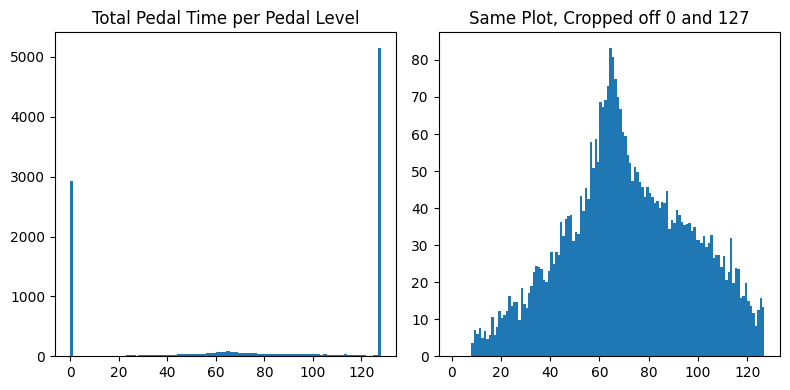

Fraction no pedal: 0.247
Fraction full pedal: 0.434
Fraction 1-126 pedal: 0.319
Total duration: 11866.424


In [9]:


def plot_pedal_level_time(all_events):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 2 rows, 2 columns
    cropped_events = all_events[(0 < all_events['level']) & (all_events['level'] < 127)]
    axes[0].hist(all_events['level'], bins=range(0, 129), weights=all_events['duration'])
    axes[1].hist(cropped_events['level'], bins=range(1, 128), weights=cropped_events['duration'])
    axes[0].set_title("Total Pedal Time per Pedal Level")
    axes[1].set_title("Same Plot, Cropped off 0 and 127")
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    events_0 = all_events[all_events['level'] == 0]
    events_127 = all_events[all_events['level'] == 127]

    total_duration = all_events['duration'].sum()
    fraction_no_pedal = events_0['duration'].sum()/total_duration
    fraction_full_pedal = events_127['duration'].sum()/total_duration
    print(f"Fraction no pedal: {fraction_no_pedal:.3f}")
    print(f"Fraction full pedal: {fraction_full_pedal:.3f}")
    print(f"Fraction 1-126 pedal: {1-fraction_no_pedal-fraction_full_pedal:.3f}")
    print(f"Total duration: {total_duration:.3f}")

# aggregate 
plot_pedal_level_time(all_events)

## Half Pedaling Peak
There's a sharp peak at exactly 64; we suspect this corresponds to pianists half-pedaling.

In [10]:
maestro_subset

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,pedal_events
101,Domenico Scarlatti,"Sonata in C Major, K. 179",train,2009,2009/MIDI-Unprocessed_14_R1_2009_01-05_ORIG_MI...,2009/MIDI-Unprocessed_14_R1_2009_01-05_ORIG_MI...,132.728233,level duration 0 0 5.652344 1 ...
51,Claude Debussy,"Etude ""Pour les huit doigts""",train,2009,2009/MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MI...,2009/MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MI...,90.996170,level duration 0 0 0.864583 1 ...
76,Claude Debussy,"Preludes Book II: “Feux d'artifice,” L 123, No...",train,2014,2014/MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO...,2014/MIDI-UNPROCESSED_06-08_R1_2014_MID--AUDIO...,257.919080,level duration 0 0 0.001302 1 ...
644,Frédéric Chopin,"Scherzo No. 1 in B Minor, Op. 20",validation,2011,2011/MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1...,2011/MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1...,506.003767,level duration 0 40 0.001302 1 ...
425,Franz Schubert,"Sonata in C Minor, D. 958 (Complete)",train,2014,2014/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_...,2014/MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_...,1790.898316,level duration 0 0 0.001302 ...
745,Johann Sebastian Bach,"Prelude and Fugue in A Minor, WTC II, BWV 889",train,2015,2015/MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-fr...,2015/MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-fr...,236.185417,level duration 0 0 11.978125 1 ...
1211,Sergei Rachmaninoff,Polka de W.R.,validation,2004,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORI...,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORI...,243.356120,level duration 0 58 0.001042 1 ...
1236,Sergei Rachmaninoff / György Cziffra,Flight of B.B.,train,2006,2006/MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MI...,2006/MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MI...,114.583219,level duration 0 0 3.410156 1 ...
596,Frédéric Chopin,Etude Op. 25 No. 6,train,2013,2013/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_03_...,2013/ORIG-MIDI_01_7_6_13_Group__MID--AUDIO_03_...,120.675627,level duration 0 0 0.001302 1 ...
275,Franz Liszt,"Valse de l'opera Faust de Charles Gounod, S.407",train,2017,2017/MIDI-Unprocessed_072_PIANO072_MID--AUDIO-...,2017/MIDI-Unprocessed_072_PIANO072_MID--AUDIO-...,549.447094,level duration 0 0 0.001042 1 ...


In [11]:
maestro_subset['num_pedal_events'] = [len(x) for x in maestro_subset['pedal_events']]
maestro_subset['num_pedal_events'].describe()

count       26.000000
mean      5631.115385
std       6901.072040
min        462.000000
25%       1725.750000
50%       3693.500000
75%       6027.500000
max      34031.000000
Name: num_pedal_events, dtype: float64

In [12]:
maestro_subset['num_pedal_events_normalized'] = maestro_subset['num_pedal_events'] / maestro_subset['duration']
maestro_subset['num_pedal_events_normalized'].describe()

count    26.000000
mean     12.252951
std       6.177847
min       1.956090
25%       7.898560
50%      11.510024
75%      16.379435
max      26.089010
Name: num_pedal_events_normalized, dtype: float64

In [13]:
pd.set_option('display.max_colwidth', 150)
maestro_subset.sort_values(by='num_pedal_events_normalized', ascending=False)

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,pedal_events,num_pedal_events,num_pedal_events_normalized
51,Claude Debussy,"Etude ""Pour les huit doigts""",train,2009,2009/MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_03_WAV.midi,2009/MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_03_WAV.wav,90.996170,level duration 0 0 0.864583 1 91 0.020833 2 127 1.240885 3 62 0.020833 4 0 0.118490 ... ... ...,2374,26.089010
1236,Sergei Rachmaninoff / György Cziffra,Flight of B.B.,train,2006,2006/MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_08_Track08_wav.midi,2006/MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_08_Track08_wav.wav,114.583219,level duration 0 0 3.410156 1 30 0.019531 2 32 0.019531 3 34 0.019531 4 35 0.019531 ... ... ...,2880,25.134571
1142,Robert Schumann,Fantasie Op. 17,train,2018,2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--4.midi,2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--4.wav,1894.080638,level duration 0 54 0.001302 1 54 0.020833 2 55 0.037760 3 55 0.040365 4 56 0.065104 ... ...,34031,17.967028
1030,Ludwig van Beethoven,"Sonata No. 5 in C Minor, Op. 10 No. 1, I. Allegro molto e con brio",test,2015,2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--2.midi,2015/MIDI-Unprocessed_R1_D2-13-20_mid--AUDIO-from_mp3_16_R1_2015_wav--2.wav,236.041667,level duration 0 51 0.001042 1 52 0.015625 2 53 0.063542 3 54 0.018750 4 55 0.100000 ... ... ...,4055,17.179170
1211,Sergei Rachmaninoff,Polka de W.R.,validation,2004,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_12_Track12_wav.midi,2004/MIDI-Unprocessed_SMF_13_01_2004_01-05_ORIG_MID--AUDIO_13_R1_2004_12_Track12_wav.wav,243.356120,level duration 0 58 0.001042 1 60 0.191667 2 61 0.060417 3 62 0.057292 4 63 0.040625 ... ... ...,4120,16.929921
371,Franz Schubert,Sonata in A D962,train,2006,2006/MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_04_Track04_wav.midi,2006/MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_04_Track04_wav.wav,648.601114,level duration 0 0 0.001302 1 50 0.019531 2 69 0.019531 3 93 0.020833 4 127 2.140625 ... ...,10886,16.783813
864,Johann Sebastian Bach / Franz Liszt,"Prelude and Fugue in A Minor, S.462/1",train,2011,2011/MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_03_Track03_wav.midi,2011/MIDI-Unprocessed_25_R3_2011_MID--AUDIO_R3-D9_03_Track03_wav.wav,362.185802,level duration 0 0 0.001302 1 40 0.019531 2 71 0.019531 3 101 0.019531 4 127 4.356771 ... ...,5969,16.480491
63,Claude Debussy,Jardins sous la pluie from Estampes,test,2011,2011/MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_05_Track05_wav.midi,2011/MIDI-Unprocessed_04_R3_2011_MID--AUDIO_R3-D2_05_Track05_wav.wav,207.262079,level duration 0 0 0.001302 1 9 0.020833 2 35 0.019531 3 47 0.019531 4 53 0.019531 ... ... ...,3332,16.076264
1223,Sergei Rachmaninoff,"Prelude in G-Sharp Minor,Op. 32 No. 12",test,2011,2011/MIDI-Unprocessed_03_R2_2011_MID--AUDIO_R2-D1_06_Track06_wav.midi,2011/MIDI-Unprocessed_03_R2_2011_MID--AUDIO_R2-D1_06_Track06_wav.wav,127.737586,level duration 0 0 0.001302 1 27 0.020833 2 37 0.019531 3 43 0.019531 4 49 0.020833 ... ... ...,2047,16.025041
1061,Ludwig van Beethoven,"Thirty-Two Variations in C Minor, WoO 80",train,2015,2015/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_19_R2_2015_wav--2.midi,2015/MIDI-Unprocessed_R2_D2-19-21-22_mid--AUDIO-from_mp3_19_R2_2015_wav--2.wav,649.673958,level duration 0 0 2.537500 1 72 0.020833 2 127 0.731250 3 84 0.020833 4 61 0.019792 ... ...,10054,15.475455


In [14]:
ballade_df = maestro_df[maestro_df['canonical_title'] == 'Ballade No. 1 in G Minor, Op. 23']
ballade_df = ballade_df.drop_duplicates(subset=['year'], keep='first')
ballade_df

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
504,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",train,2004,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav.midi,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav.wav,551.649014
507,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",train,2015,2015/MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--5.midi,2015/MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--5.wav,511.256250
508,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",train,2013,2013/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--3.midi,2013/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--3.wav,590.019442
510,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",train,2011,2011/MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_03_Track03_wav.midi,2011/MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_03_Track03_wav.wav,538.139152
513,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",train,2017,2017/MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--4.midi,2017/MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--4.wav,558.778245


# Compare Ballade Performances

In [15]:
ballade_df = add_pedal_events_col(ballade_df)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.18it/s]


In [16]:
ballade_df

,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration,pedal_events
504,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",train,2004,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav.midi,2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav.wav,551.649014,level duration 0 46 0.001042 1 48 0.059375 2 52 0.040625 3 54 0.018750 4 56 0.018750 ... ... ...
507,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",train,2015,2015/MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--5.midi,2015/MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--5.wav,511.256250,level duration 0 0 0.001042 1 19 0.020833 2 64 0.018750 3 102 0.018750 4 127 5.694792 ... ... ...
508,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",train,2013,2013/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--3.midi,2013/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--3.wav,590.019442,level duration 0 0 0.022135 1 40 0.020833 2 87 0.029948 3 127 8.532552 4 86 0.019531 ... ... ...
510,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",train,2011,2011/MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_03_Track03_wav.midi,2011/MIDI-Unprocessed_04_R2_2011_MID--AUDIO_R2-D2_03_Track03_wav.wav,538.139152,level duration 0 0 0.001302 1 21 0.019531 2 25 0.079427 3 24 0.019531 4 23 0.028646 ... ... ...
513,Frédéric Chopin,"Ballade No. 1 in G Minor, Op. 23",train,2017,2017/MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--4.midi,2017/MIDI-Unprocessed_046_PIANO046_MID--AUDIO-split_07-06-17_Piano-e_2-02_wav--4.wav,558.778245,level duration 0 0 0.007292 1 70 0.019792 2 127 4.853125 3 98 0.019792 4 79 0.019792 ... ... ...


Performance ind: 504
File: 2004/MIDI-Unprocessed_SMF_12_01_2004_01-05_ORIG_MID--AUDIO_12_R1_2004_07_Track07_wav.midi


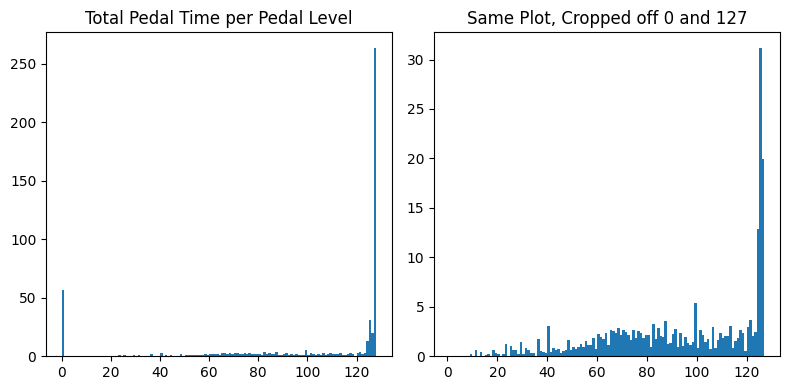

Fraction no pedal: 0.102
Fraction full pedal: 0.478
Fraction 1-126 pedal: 0.420
Total duration: 551.792
Performance ind: 507
File: 2015/MIDI-Unprocessed_R2_D2-12-13-15_mid--AUDIO-from_mp3_12_R2_2015_wav--5.midi


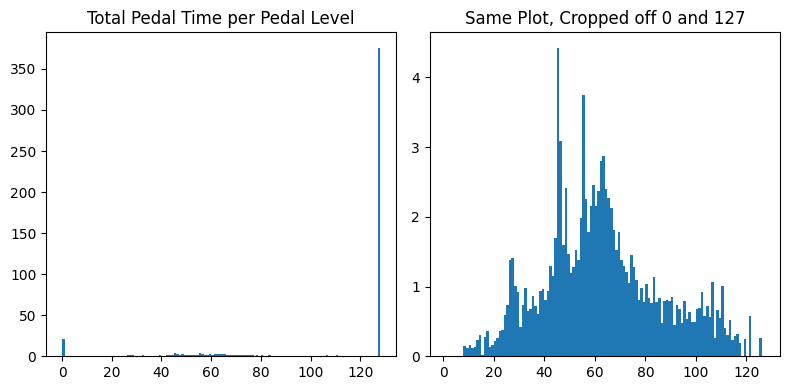

Fraction no pedal: 0.041
Fraction full pedal: 0.735
Fraction 1-126 pedal: 0.224
Total duration: 511.235
Performance ind: 508
File: 2013/ORIG-MIDI_02_7_8_13_Group__MID--AUDIO_12_R2_2013_wav--3.midi


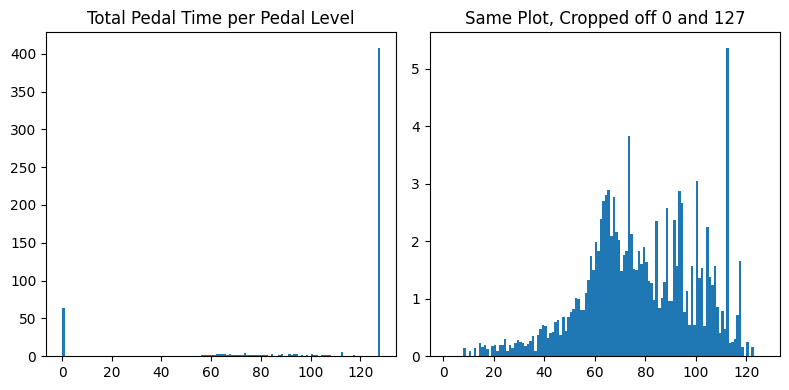

Fraction no pedal: 0.107
Fraction full pedal: 0.691
Fraction 1-126 pedal: 0.202
Total duration: 590.021


In [17]:
for ind, row in list(ballade_df.iterrows())[:3]:
    print("Performance ind:", ind)
    print("File:", row['midi_filename'])
    plot_pedal_level_time(row['pedal_events'])

# fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# for _, row in list(ballade_df.iterrows())[:2]:
#     # check that pedal events duration matches up with duration given in the data
#     print(sum(row['pedal_events']['duration']), row['duration'])
#     pedal_events = row['pedal_events']
#     cropped_events = pedal_events[(pedal_events['level'] > 0) & (pedal_events['level'] < 127)]
#     axes[0].hist(pedal_events['level'], bins=range(129), weights=row['pedal_events']['duration'], alpha=0.5)
#     axes[1].hist(cropped_events['level'], alpha=0.2, bins=range(1, 128), weights=cropped_events['duration'])
# plt.show()